In [15]:
%pip install tensorflow==2.18.1 opencv-python matplotlib
import tensorflow as tf, cv2, matplotlib

Note: you may need to restart the kernel to use updated packages.


In [16]:
import sys
print(sys.executable)

C:\Users\victor\AppData\Local\Programs\Python\Python312\python.exe


In [17]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [18]:
# Import tensorflow dependencies - Functional API
from keras.models import Model
from keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [19]:
tf.config.list_physical_devices('GPU')

[]

In [20]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [21]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')


In [22]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

In [23]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [24]:
# Import uuid library to generate unique image names
import uuid

In [25]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\762542ac-d088-11f0-a65f-ec2e98610d9a.jpg'

In [26]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]

    #collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        #create the unique file path
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        #write out anchor image
        cv2.imwrite(imgname, frame)
    #collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        #create the unique file path
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        #write out anchor image
        cv2.imwrite(imgname, frame)
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break


# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [27]:
anchor = tf.data.Dataset.list_files(rf"{ANC_PATH}\*.jpg").take(750)
positive = tf.data.Dataset.list_files(rf"{POS_PATH}\*.jpg").take(311)
negative = tf.data.Dataset.list_files(rf"{NEG_PATH}\*.jpg").take(300)

In [28]:
dir_test = anchor.as_numpy_iterator()

In [29]:
print(dir_test.next())

b'data\\anchor\\8edd2f5e-c281-11f0-b79b-ec2e98610d9a.jpg'


In [30]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

In [31]:
img = preprocess('data\\anchor\\8e096a2a-c281-11f0-9bbf-ec2e98610d9a.jpg')

In [32]:
img.numpy().max() 

np.float32(1.0)

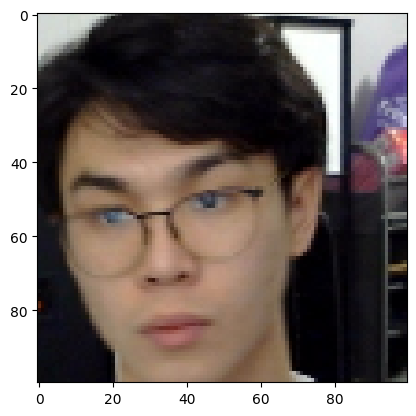

In [33]:
plt.imshow(img)

In [34]:
dataset.map(preprocess)

NameError: name 'dataset' is not defined

In [35]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [36]:
samples = data.as_numpy_iterator()

In [37]:
exampple = samples.next()

In [38]:
exampple

(b'data\\anchor\\8f434a3b-c281-11f0-b956-ec2e98610d9a.jpg',
 b'data\\positive\\d1d03ee9-cb28-11f0-8a4c-ec2e98610d9a.jpg',
 np.float32(1.0))

In [39]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [40]:
res = preprocess_twin(*exampple)

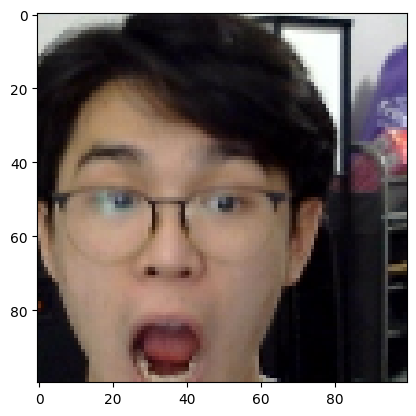

In [41]:
plt.imshow(res[0])


In [42]:
res[0]

<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[0.8264706 , 0.84607846, 0.8186275 ],
        [0.8242647 , 0.8514706 , 0.8267157 ],
        [0.81764704, 0.85294116, 0.84068626],
        ...,
        [0.8522059 , 0.8656863 , 0.87034315],
        [0.84705883, 0.87009805, 0.87034315],
        [0.8362745 , 0.8598039 , 0.8598039 ]],

       [[0.8362745 , 0.84607846, 0.82058823],
        [0.83259803, 0.84044117, 0.82279414],
        [0.8267157 , 0.84117645, 0.83455884],
        ...,
        [0.84387255, 0.86740196, 0.8610294 ],
        [0.82916665, 0.86446077, 0.860049  ],
        [0.827451  , 0.8637255 , 0.8598039 ]],

       [[0.842402  , 0.84632355, 0.8267157 ],
        [0.84044117, 0.847549  , 0.83431375],
        [0.8372549 , 0.845098  , 0.83480394],
        ...,
        [0.8387255 , 0.8629902 , 0.8504902 ],
        [0.82843137, 0.8637255 , 0.85343134],
        [0.83137256, 0.86764705, 0.8637255 ]],

       ...,

       [[0.04313726, 0.05588235, 0.06960785],
        [0.03

In [43]:
#build data loader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [44]:
# train partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [45]:
#testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [46]:
inp = Input(shape=(100,100,3), name='input_image')

In [47]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [48]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [49]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [50]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [51]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [52]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [53]:
mod.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [54]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=inp, outputs=d1, name='embedding')

In [55]:
embedding = make_embedding()

In [56]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [57]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [58]:
l1 = L1Dist()

In [59]:
l1(anchor_embedding, validation_embedding)

NameError: name 'anchor_embedding' is not defined

In [60]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [61]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [62]:
siamese_layer = L1Dist()

In [63]:
distances = siamese_layer(inp_embedding, val_embedding)

In [64]:
classifier = Dense(1, activation='sigmoid')(distances)

In [65]:
classifier

<KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=keras_tensor_21>

In [66]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [67]:
siamese_network.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_1 (L1Dist)            │ (None, 4096)              │               0 │ embedding[0][0],           │
│                               │                           │                 │ embedding[1][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 1)                 │           4,097 │ l1_dist_1[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [68]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [69]:
siamese_model = make_siamese_model()

In [70]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_2 (L1Dist)            │ (None, 4096)              │               0 │ embedding[2][0],           │
│                               │                           │                 │ embedding[3][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 1)                 │           4,097 │ l1_dist_2[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [71]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [72]:
opt = tf.keras.optimizers.Adam(1e-4) #0.0001

In [73]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [74]:
test_batch = train_data.as_numpy_iterator()

In [88]:
batch_1 = test_batch.next()

In [89]:
X = batch_1[:2]

In [90]:
y = batch_1[2]

In [91]:
y

array([1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0.],
      dtype=float32)

In [92]:
X

(array([[[[1.04166664e-01, 1.19852938e-01, 1.23774506e-01],
          [1.07107840e-01, 1.22794114e-01, 1.28676474e-01],
          [1.15441173e-01, 1.28186271e-01, 1.45833328e-01],
          ...,
          [3.29411775e-01, 2.29411766e-01, 2.31372550e-01],
          [3.96323532e-01, 2.56127447e-01, 2.71813720e-01],
          [4.05392170e-01, 2.52450973e-01, 2.64215678e-01]],
 
         [[1.29656866e-01, 1.53186277e-01, 1.53186277e-01],
          [1.33578435e-01, 1.56127453e-01, 1.59068629e-01],
          [1.32107839e-01, 1.51715681e-01, 1.63480386e-01],
          ...,
          [3.46813738e-01, 2.49264702e-01, 2.44607836e-01],
          [3.92892152e-01, 2.54166663e-01, 2.62990206e-01],
          [4.12254900e-01, 2.50735283e-01, 2.66421556e-01]],
 
         [[1.17647059e-01, 1.47058830e-01, 1.52941182e-01],
          [1.30637258e-01, 1.53921574e-01, 1.54656857e-01],
          [1.37500003e-01, 1.60049021e-01, 1.62990198e-01],
          ...,
          [3.21078420e-01, 2.36029416e-01, 2.4558

In [93]:
tf.losses.BinaryCrossentropy??

Init signature:
tf.losses.BinaryCrossentropy(
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction='sum_over_batch_size',
    name='binary_crossentropy',
    dtype=None,
)
Source:        
@keras_export("keras.losses.BinaryCrossentropy")
class BinaryCrossentropy(LossFunctionWrapper):
    """Computes the cross-entropy loss between true labels and predicted labels.

    Use this cross-entropy loss for binary (0 or 1) classification applications.
    The loss function requires the following inputs:

    - `y_true` (true label): This is either 0 or 1.
    - `y_pred` (predicted value): This is the model's prediction, i.e, a single
        floating-point value which either represents a
        [logit](https://en.wikipedia.org/wiki/Logit), (i.e, value in [-inf, inf]
        when `from_logits=True`) or a probability (i.e, value in [0., 1.] when
        `from_logits=False`).

    Args:
        from_logits: Whether to interpret `y_pred` as a tensor of
            [logit](htt

In [94]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)

    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))\

    return loss

In [95]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [96]:
EPOCHS = 40

In [97]:
train(train_data, EPOCHS)


 Epoch 1/40
Tensor("binary_crossentropy/div_no_nan:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/div_no_nan:0", shape=(), dtype=float32)
26/27 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/stepTensor("binary_crossentropy/div_no_nan:0", shape=(), dtype=float32)
27/27 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step

 Epoch 2/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step

 Epoch 3/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step

 Epoch 4/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step

 Epoch 5/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step

 Epoch 6/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step

 Epoch 7/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step

 Epoch 8/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step

 Epoch 9/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step

 Epoch 10/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step

 Epoch 11/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step

 Epoch 12/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step

 Epoch 13/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step

 Epoch 14/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step

 Epoch 15/40
27/27 ━━━━━━

In [98]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [99]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [100]:
#make preditions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


array([[1.0000000e+00],
       [9.9998885e-01],
       [1.0000000e+00],
       [3.1995762e-09],
       [5.9372606e-08],
       [9.9999994e-01],
       [1.0000000e+00],
       [1.7719569e-04],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [2.1496897e-08],
       [9.9999994e-01]], dtype=float32)

In [101]:
#post processing the results
[1 if prediction >  0.5 else 0 for prediction  in y_hat]

[1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1]

In [102]:
y_true

array([1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1.],
      dtype=float32)

In [103]:
#Creating a  metric oject
m = Recall()
#Calculating the recall value
m.update_state(y_true, y_hat)
##Return Recall Result
m.result().numpy()

np.float32(1.0)

In [104]:
#Creating a  metric oject
m = Precision()
#Calculating the recall value
m.update_state(y_true, y_hat)
##Return Recall Result
m.result().numpy()

np.float32(1.0)

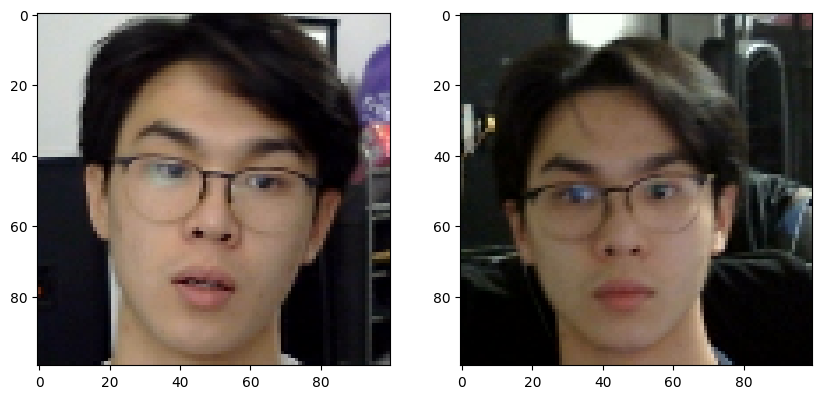

In [105]:
#set plot size
plt.figure(figsize=(10,8))

#set first suplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

#set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[1])

#Renders Cleanly
plt.show()

In [106]:
#save weights
siamese_model.save('siamesemodel.keras')

In [107]:
L1Dist

__main__.L1Dist

In [108]:
# Reload model 
model = tf.keras.models.load_model('siamesemodel.keras', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [109]:
#make predictions with reloaded model
model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


array([[1.0000000e+00],
       [9.9998885e-01],
       [1.0000000e+00],
       [3.1995762e-09],
       [5.9372606e-08],
       [9.9999994e-01],
       [1.0000000e+00],
       [1.7719569e-04],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [2.1496897e-08],
       [9.9999994e-01]], dtype=float32)

In [110]:
#view model summary
model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_4 (L1Dist)            │ (None, 4096)              │               0 │ embedding[0][0],           │
│                               │                           │                 │ embedding[1][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 1)                 │           4,097 │ l1_dist_4[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [111]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [112]:
os.listdir(os.path.join('application_data', 'verification_images'))

['473da280-c281-11f0-9529-ec2e98610d9a.jpg',
 '476ac440-c281-11f0-bb68-ec2e98610d9a.jpg',
 '483e4cf1-c281-11f0-b8ca-ec2e98610d9a.jpg',
 '485d758b-c281-11f0-8577-ec2e98610d9a.jpg',
 '488ade1e-c281-11f0-bee4-ec2e98610d9a.jpg',
 '498a5709-c281-11f0-9161-ec2e98610d9a.jpg',
 '499fbb9d-c281-11f0-be6d-ec2e98610d9a.jpg',
 '49ccd831-c281-11f0-ab63-ec2e98610d9a.jpg',
 '49f56112-c281-11f0-b314-ec2e98610d9a.jpg',
 '506bc3e2-c281-11f0-90ce-ec2e98610d9a.jpg',
 '50cb7e2c-c281-11f0-8563-ec2e98610d9a.jpg',
 '5cfa5e3b-c281-11f0-af70-ec2e98610d9a.jpg',
 '5d5ef065-c281-11f0-82e1-ec2e98610d9a.jpg',
 '5ea46889-c281-11f0-8510-ec2e98610d9a.jpg',
 '5fb942da-c281-11f0-803a-ec2e98610d9a.jpg',
 '5fc55318-c281-11f0-a57e-ec2e98610d9a.jpg',
 '60c102c6-c281-11f0-ae80-ec2e98610d9a.jpg',
 '618a250d-c281-11f0-a996-ec2e98610d9a.jpg',
 '644f342a-c281-11f0-99b6-ec2e98610d9a.jpg',
 '691c93fc-c281-11f0-8094-ec2e98610d9a.jpg',
 '694a1a69-c281-11f0-bf1d-ec2e98610d9a.jpg',
 '69776a02-c281-11f0-bb3d-ec2e98610d9a.jpg',
 '6f5886f3

In [113]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\473da280-c281-11f0-9529-ec2e98610d9a.jpg
application_data\verification_images\476ac440-c281-11f0-bb68-ec2e98610d9a.jpg
application_data\verification_images\483e4cf1-c281-11f0-b8ca-ec2e98610d9a.jpg
application_data\verification_images\485d758b-c281-11f0-8577-ec2e98610d9a.jpg
application_data\verification_images\488ade1e-c281-11f0-bee4-ec2e98610d9a.jpg
application_data\verification_images\498a5709-c281-11f0-9161-ec2e98610d9a.jpg
application_data\verification_images\499fbb9d-c281-11f0-be6d-ec2e98610d9a.jpg
application_data\verification_images\49ccd831-c281-11f0-ab63-ec2e98610d9a.jpg
application_data\verification_images\49f56112-c281-11f0-b314-ec2e98610d9a.jpg
application_data\verification_images\506bc3e2-c281-11f0-90ce-ec2e98610d9a.jpg
application_data\verification_images\50cb7e2c-c281-11f0-8563-ec2e98610d9a.jpg
application_data\verification_images\5cfa5e3b-c281-11f0-af70-ec2e98610d9a.jpg
application_data\verification_images\5d5ef065-c281-11f0-82e1-ec2

In [114]:
VER_PATH = os.path.join('application_data', 'verification_images')

In [115]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]

    #collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        #create the unique file path
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        #write out anchor image
        cv2.imwrite(imgname, frame)
    #collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        #create the unique file path
        imgname = os.path.join(VER_PATH, '{}.jpg'.format(uuid.uuid1()))
        #write out anchor image
        cv2.imwrite(imgname, frame)
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break


# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [291]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [292]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.9, 0.9)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━

In [152]:
np.squeeze(results) > 0.5

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,